In [1]:
%matplotlib inline 
import xarray as xr
import os 
import pandas as pd
import numpy as np

In [2]:
pip install git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix

  Cloning https://github.com/dgergel/xsd.git (to revision pointwisedownscaler_interimfix) to /tmp/pip-req-build-nl1xqioy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-downscale: filename=scikit_downscale-0.0.1.post262-py3-none-any.whl size=22371 sha256=7ebc755ed4e06b1f71dad6ea25f3da5f69ec5a7ee659344afe9f748210f00c19
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhzv2djl/wheels/31/9a/21/7637b2b133bbb6aa5a89cab830ed35b8bd59ca457f8b4fdc98
Successfully built scikit-downscale
  Attempting uninstall: scikit-downscale
    Found existing installation: scikit-downscale 0.0.1.post261
    Uninstalling scikit-downscale-0.0.1.post261:
      Successfully uninstalled scikit-downscale-0.0.1.post261
Note: you may need to restart the kernel to use updated packages.


In [3]:
import skdownscale

In [4]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

from utils import _convert_lons, _remove_leap_days, _convert_ds_longitude
from regridding import apply_weights

import intake
import xesmf as xe

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# output directory
write_direc = '/gcs/rhg-data/climate/downscaled/workdir'

This notebook implements a scaling test for bias correction, using the BCSDTemperature model from `scikit-downscale`, with the daily BCSD bias correction method as implemented in the NASA-NEX dataset. 

Datasets used include a CMIP6 model from a historical run (`GISS-E2-1-G` from NASA) and GMFD (obs). Historical/training period is taken as 1980-1982, and the future/predict period is 1990-1991. 

GMFD is coarsened to the NASA `GISS-E2-1-G` grid for this bias correction test. 

Note that the purpose of this notebook is intended to allow us to get a better estimate of timing for global daily bias correction. Future work will build on this notebook to: 
- replace GMFD with ERA5
- combine this notebook with `SD_prototype.ipynb`, along with NASA-NEX data and a corresponding CMIP5 model, and over a limited domain, to test our implementation of BCSD against NASA-NEX for a limited domain. That notebook will be used as a prototype for our downscaling pipeline and can be modified to become a system test for the pipeline (1-3 gridcells for CI/CD, limited domain for science testing). 

This notebook was also used as a resource and checkpoint for this workflow: https://github.com/jhamman/scikit-downscale/blob/ecahm2020/examples/2020ECAHM-scikit-downscale.ipynb

In [7]:
'''client, cluster = rhgk.get_standard_cluster(
    extra_pip_packages="git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix")'''

# name='rhodium/worker:coastal-gateway'
# name='gcr.io/rhg-project-1/pytc-image-gateway:latest'
client, cluster = rhgk.get_standard_cluster(name='rhodium/worker:coastal-gateway', 
    extra_pip_packages="git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix")

# client, cluster = rhgk.get_standard_cluster(extra_pip_packages="git+https://github.com/jhamman/scikit-downscale.git")

In [8]:
cluster

In [10]:
'''a = da.ones((1000, 1000, 1000))
a.mean().compute()'''

'a = da.ones((1000, 1000, 1000))\na.mean().compute()'

In [11]:
from skdownscale.pointwise_models import PointWiseDownscaler, BcsdTemperature

In [12]:
train_slice = slice('1980', '1989')  # train time range
holdout_slice = slice('1990', '2000')  # prediction time range

In [13]:
# client.get_versions(check=True)

In [14]:
# use GMFD as standin for ERA-5
tmax_obs = xr.open_mfdataset(os.path.join('/gcs/rhg-data/climate/source_data/GMFD/tmax', 
                                         'tmax_0p25_daily_198*'), concat_dim='time', combine='nested',
                              parallel=True).squeeze(drop=True).rename({'latitude': 'lat', 'longitude': 'lon'})

# standardize longitudes 
tmax_obs =  _convert_ds_longitude(tmax_obs, lon_name='lon')

# remove leap days 
tmax_obs = _remove_leap_days(tmax_obs)

obs_subset = tmax_obs.sel(time=train_slice)

get some CMIP6 data 

In [15]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

In [17]:
# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask(
           ).isel(member_id=0).squeeze(drop=True).drop(['height', 'member_id'])


ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

regrid obs to model resolution 

In [18]:
# first rechunk in space for xESMF 
chunks = {'lat': len(obs_subset.lat), 'lon': len(obs_subset.lon), 'time': 100}
obs_subset = obs_subset.chunk(chunks)

In [19]:
%%time
obs_to_mod_weights = os.path.join(write_direc, 'bias_correction_bilinear_weights_new.nc')

regridder_obs_to_mod = xe.Regridder(obs_subset.isel(time=0, drop=True), 
                                    ds_model.isel(time=0, drop=True), 
                                    'bilinear', 
                                    filename=obs_to_mod_weights, 
                                    reuse_weights=True)

obs_subset_modres_lazy = xr.map_blocks(apply_weights, regridder_obs_to_mod, 
                                args=[tmax_obs['tmax']])

obs_subset_modres = obs_subset_modres_lazy.compute()

CPU times: user 637 ms, sys: 480 ms, total: 1.12 s
Wall time: 22.8 s


### subset datasets to get ready for bias correcting 

In [20]:
chunks = {'lat': 10, 'lon': 10, 'time': -1}

train_subset = ds_model['tasmax'].sel(time=train_slice)
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


holdout_subset = ds_model['tasmax'].sel(time=holdout_slice)
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

### fit BcsdTemperature models at each x/y point in domain using the `PointwiseDownscaler` with the `daily_nasa-nex` option

In [21]:
%%time
# model = PointWiseDownscaler(BcsdTemperature(return_anoms=False, time_grouper='daily_nasa-nex'))
model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))

CPU times: user 15 µs, sys: 4 µs, total: 19 µs
Wall time: 22.2 µs


In [23]:
# remove leap days from model data
train_subset_noleap = _remove_leap_days(train_subset)

holdout_subset_noleap = _remove_leap_days(holdout_subset)

In [24]:
# chunk datasets 
train_subset_noleap = train_subset_noleap.chunk(chunks)
holdout_subset_noleap = holdout_subset_noleap.chunk(chunks)
obs_subset_modres = obs_subset_modres.chunk(chunks)

In [25]:
%%time
model.fit(train_subset_noleap, obs_subset_modres)

CPU times: user 202 ms, sys: 251 µs, total: 203 ms
Wall time: 200 ms


In [26]:
model

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(return_anoms=False)

In [27]:
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(return_anoms=False)

<xarray.DataArray 'tasmax' (lat: 90, lon: 144)>
dask.array<_fit_wrapper-45f8d854859d386ca09ca764193055f5-<this, shape=(90, 144), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

In [28]:
%%time
predicted = model.predict(holdout_subset_noleap).load()

CPU times: user 2.54 s, sys: 1.16 s, total: 3.69 s
Wall time: 1min 32s


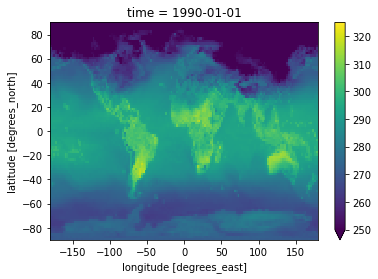

In [29]:
predicted.isel(time=0).plot(vmin=250, vmax=325)

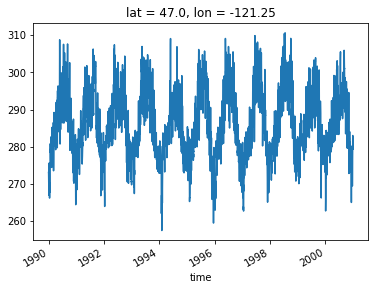

In [30]:
predicted.sel(lat=47, lon=-122, method='nearest').plot()

### save data

In [31]:
ds_predicted = predicted.to_dataset(name='tmax')

ds_new_attrs = {"file description": "daily bias correction test for 1980s, output from global bias correction scaling test",
                   "author": "Diana Gergel", "contact": "dgergel@rhg.com"}
ds_predicted.attrs.update(ds_new_attrs)
ds_predicted.to_netcdf(os.path.join(write_direc, 'global_bias_corrected_tenyears_newest.nc'))